# Import necessary Libraries

In [ ]:
from timeit import default_timer
start = default_timer()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 700 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d grouplens/movielens-20m-dataset

 99% 194M/195M [00:02<00:00, 87.6MB/s]
100% 195M/195M [00:02<00:00, 90.4MB/s]


In [ ]:
!unzip movielens-20m-dataset.zip

Archive:  movielens-20m-dataset.zip
  inflating: genome_scores.csv       
  inflating: genome_tags.csv         
  inflating: link.csv                
  inflating: movie.csv               
  inflating: rating.csv              
  inflating: tag.csv                 


In [ ]:
import pandas as pd
tag = pd.read_csv("/content/tag.csv")
movies = pd.read_csv("/content/movie.csv")
rating = pd.read_csv("/content/rating.csv")
link = pd.read_csv("/content/link.csv")
genome_tags = pd.read_csv("/content/genome_tags.csv")
genome_scores = pd.read_csv("/content/genome_scores.csv")

# Exploratory Data Analysis

In [ ]:
#considered as high demand movies and thus more requested
d = rating["rating"]>3.5
d

0           False
1           False
2           False
3           False
4           False
            ...  
20000258     True
20000259     True
20000260    False
20000261     True
20000262    False
Name: rating, Length: 20000263, dtype: bool

In [ ]:
st = default_timer()

# First time data load.
movies = pd.read_csv("moviemovie.csv")
ratings = pd.read_csv("rating.csv")
    
# Organise a bit and store into feather-format
movies.sort_values(by='movieId', inplace=True)
movies.reset_index(inplace=True, drop=True)
ratings.sort_values(by='movieId', inplace=True)
ratings.reset_index(inplace=True, drop=True)

print(ratings.dtypes)

# Split title and release year in separate columns in movies dataframe. Convert year to timestamp.
movies['year'] = movies.title.str.extract("\((\d{4})\)", expand=True)
movies.year = pd.to_datetime(movies.year, format='%Y')
movies.year = movies.year.dt.year # As there are some NaN years, resulting type will be float (decimals)
movies.title = movies.title.str[:-7]

# Categorize movies genres properly. Working later with +20MM rows of strings proved very resource consuming
genres_unique = pd.DataFrame(movies.genres.str.split('|').tolist()).stack().unique()
genres_unique = pd.DataFrame(genres_unique, columns=['genre']) # Format into DataFrame to store later
movies = movies.join(movies.genres.str.get_dummies().astype(bool))
movies.drop('genres', inplace=True, axis=1)

# Modify rating timestamp format (from seconds to datetime year)
#ratings.timestamp = pd.to_datetime(ratings.timestamp, unit='s')
ratings.timestamp = pd.to_datetime(ratings.timestamp, infer_datetime_format=True)
ratings.timestamp = ratings.timestamp.dt.year

# Check and clean NaN values
print ("Number of movies Null values: ", max(movies.isnull().sum()))
print ("Number of ratings Null values: ", max(ratings.isnull().sum()))
movies.dropna(inplace=True)
ratings.dropna(inplace=True)
    
# Organise a bit, then save into feather-formatand clear from memory
movies.sort_values(by='movieId', inplace=True)
ratings.sort_values(by='movieId', inplace=True)
movies.reset_index(inplace=True, drop=True)
ratings.reset_index(inplace=True, drop=True)
    
runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

userId         int64
movieId        int64
rating       float64
timestamp     object
dtype: object
Number of movies Null values:  22
Number of ratings Null values:  0
Elapsed time(sec):  52.03


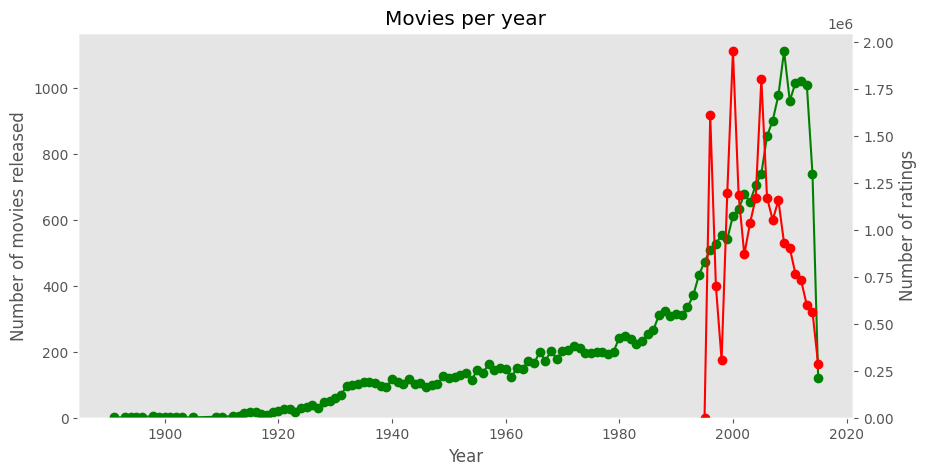

Elapsed time(sec):  0.99


In [ ]:
st = default_timer()

# Let's work with a temp smaller slice 'dftmp' of the original dataframe to reduce runtime (ratings hass +2MM rows)
dftmp = movies[['movieId', 'year']].groupby('year')

fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(dftmp.year.first(), dftmp.movieId.nunique(), "g-o")
ax1.grid(None)
ax1.set_ylim(0,)

dftmp = ratings[['rating', 'timestamp']].groupby('timestamp')
ax2 = ax1.twinx()
ax2.plot(dftmp.timestamp.first(), dftmp.rating.count(), "r-o")
ax2.grid(None)
ax2.set_ylim(0,)

ax1.set_xlabel('Year')
ax1.set_ylabel('Number of movies released'); ax2.set_ylabel('Number of ratings')
plt.title('Movies per year')
plt.show()

# Housekeeping
%reset_selective -f (^dftmp$|^ax1$|^ax2$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

**PLOT#1**: Number of movies and ratings per year.

<Figure size 1000x500 with 0 Axes>

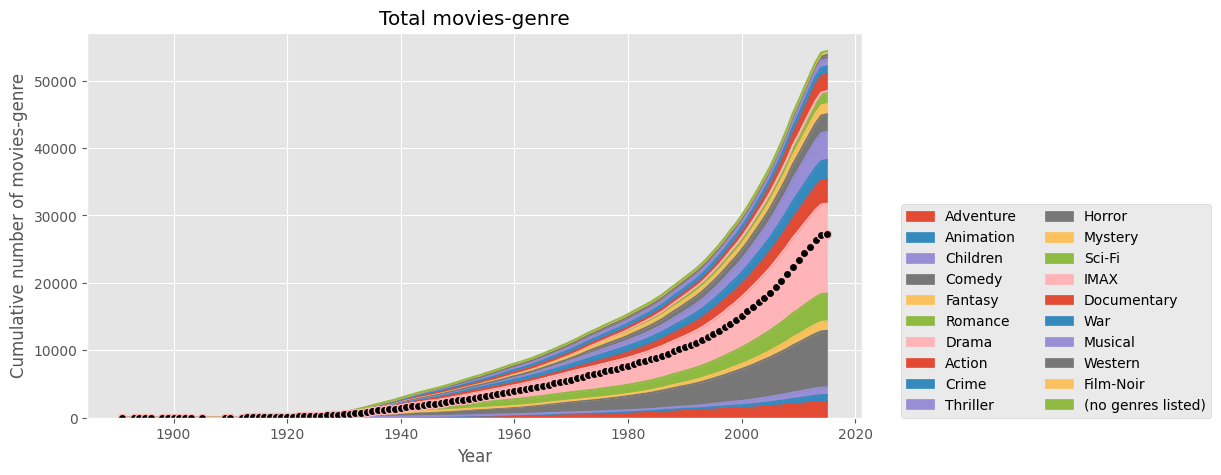

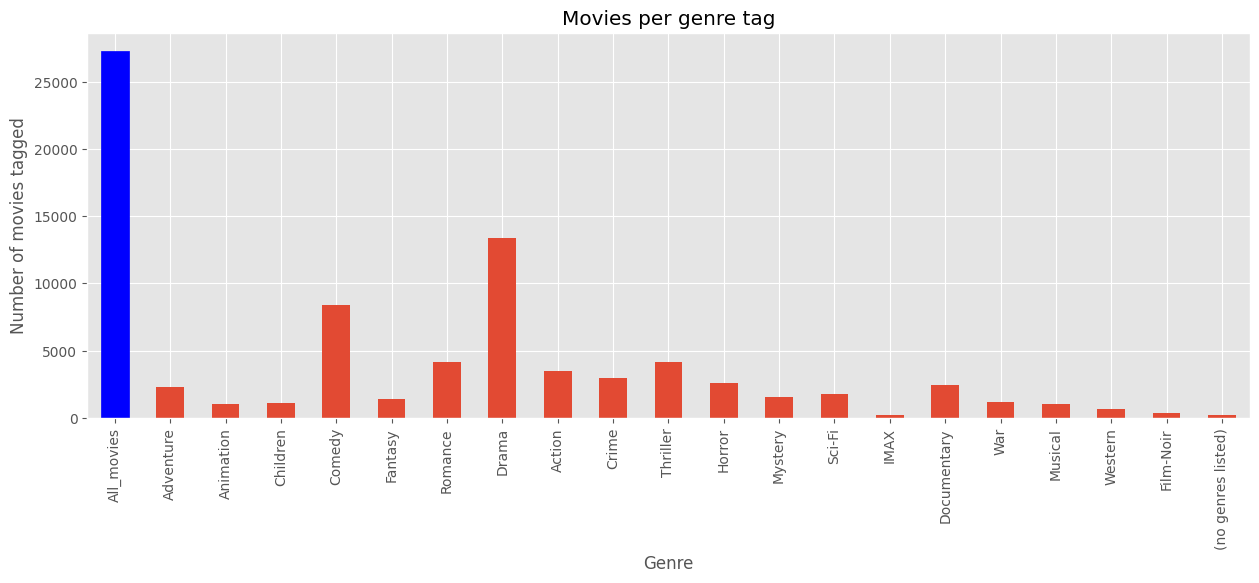

Elapsed time(sec):  0.96


In [ ]:
st = default_timer()

plt.figure(figsize=(10,5))
dftmp = movies[['movieId', 'year']].groupby('year')
df = pd.DataFrame({'All_movies' : dftmp.movieId.nunique().cumsum()})
# Plot histogram for each individual genre
for genre in genres_unique.genre:
    dftmp = movies[movies[genre]][['movieId', 'year']].groupby('year')
    df[genre]=dftmp.movieId.nunique().cumsum()
df.fillna(method='ffill', inplace=True)
df.loc[:,df.columns!='All_movies'].plot.area(stacked=True, figsize=(10,5))
# Plot histogram for all movies
plt.plot(df['All_movies'], marker='o', markerfacecolor='black')
plt.xlabel('Year')
plt.ylabel('Cumulative number of movies-genre')
plt.title('Total movies-genre') # Many movies have multiple genres, so counthere is higher than number of movies
plt.legend(loc=(1.05,0), ncol=2)
plt.show()
# Plot simple scatter of the number of movies tagged with each genre
plt.figure(figsize=(15,5))
barlist = df.iloc[-1].plot.bar()
barlist.patches[0].set_color('b') # Color 'All_movies' differently, as it's not a genre tag count
plt.xticks(rotation='vertical')
plt.title('Movies per genre tag')
plt.xlabel('Genre')
plt.ylabel('Number of movies tagged')
plt.show()

# Housekeeping
%reset_selective -f (^barlist$|^dftmp$|^genre$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

**PLOT#2**: Cumulative number of movies, in total and per genre.


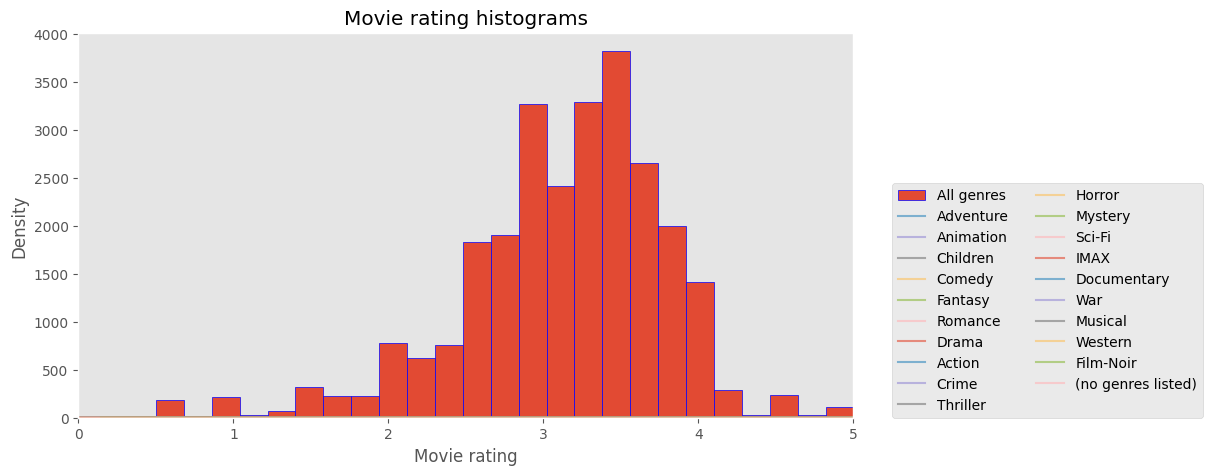

Elapsed time(sec):  15.65


In [ ]:
st = default_timer()

dftmp = ratings[['movieId','rating']].groupby('movieId').mean()

# Initialize empty list to capture basic stats by genre
rating_stats = []
# Plot general histogram of all ratings
dftmp.hist(bins=25, grid=False, edgecolor='b', label ='All genres', figsize=(10,5))
# Plot histograms (kde lines for better visibility) per genre
for genre in genres_unique.genre:
    dftmp = movies[movies[genre]==True]
    dftmp = ratings[ratings.set_index('movieId').index.isin(dftmp.set_index('movieId').index)]
    dftmp = dftmp[['movieId','rating']].groupby('movieId').mean()
    dftmp.rating.plot(grid=False, alpha=0.6, kind='kde', label=genre)
    avg = dftmp.rating.mean()
    std = dftmp.rating.std()
    rating_stats.append((genre, avg, std))
plt.legend(loc=(1.05,0), ncol=2)
plt.xlim(0,5)
plt.xlabel('Movie rating')
plt.title('Movie rating histograms')
plt.show()

# Housekeeping
%reset_selective -f (^avg$|^dftmp$|^genre$|^std$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

**PLOT#3**: Distributions by genre, on top of total rating distribution. This will help identifying consistent ratings or outliers (e.g. Comedies being rated higher in general).


In [ ]:
print("rating_sum shape:", rating_sum.shape)
print("labels shape:", len(['Average', 'STD']))


rating_sum shape: (20, 2)
labels shape: 2


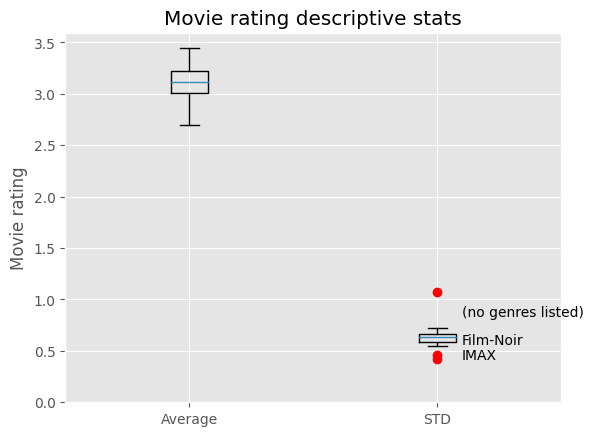

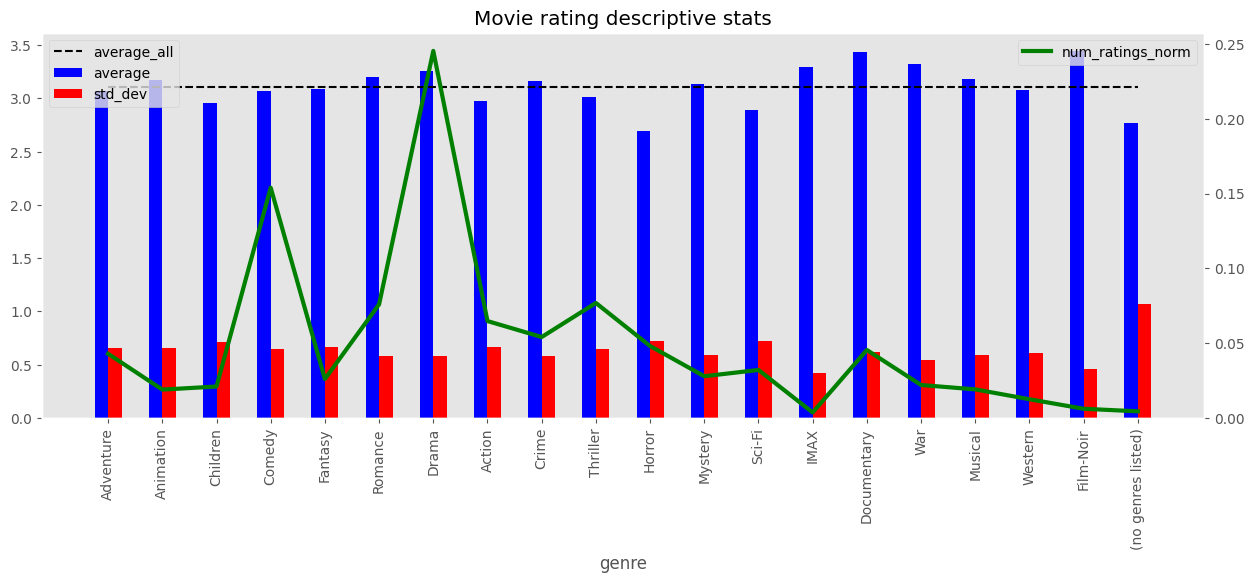

Outliers:  {'Film-Noir', 'IMAX', '(no genres listed)'}
genre             Adventure  Animation  Children    Comedy   Fantasy  \
average            3.072407   3.177095  2.955608  3.074271  3.093084   
std_dev            0.658817   0.652727  0.711403  0.648962  0.661956   
num_ratings_norm   0.042831   0.018887  0.020947  0.153910  0.025949   
average_all        3.112275   3.112275  3.112275  3.112275  3.112275   

genre              Romance     Drama    Action     Crime  Thriller    Horror  \
average           3.205743  3.262057  2.976834  3.166853  3.016069  2.696796   
std_dev           0.583832  0.581126  0.665900  0.584603  0.643598  0.720493   
num_ratings_norm  0.075897  0.245329  0.064716  0.054031  0.076817  0.048018   
average_all       3.112275  3.112275  3.112275  3.112275  3.112275  3.112275   

genre              Mystery    Sci-Fi      IMAX  Documentary       War  \
average           3.134997  2.889511  3.294670     3.436628  3.321137   
std_dev           0.593284  0.720313 

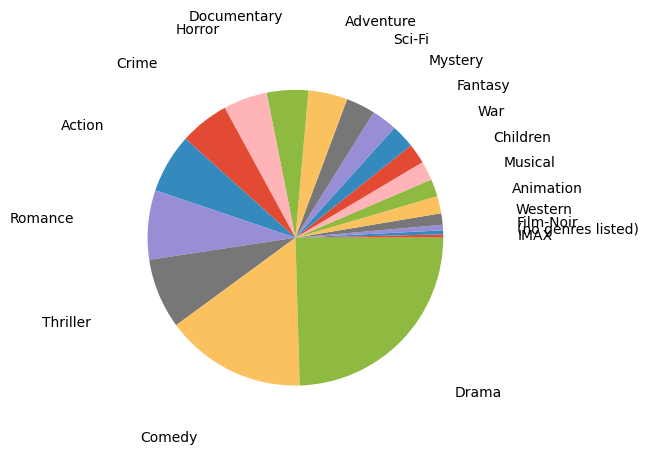

Elapsed time(sec):  1.15


In [ ]:
st = default_timer()

# Construct a DataFrame with all the basic stats per genre
rating_sum = pd.DataFrame(rating_stats,  columns=['genre', 'average', 'std_dev'])
rating_sum.set_index('genre', inplace=True)
# Display a boxplot to show the dispersion of average and standard deviation
# bxplot = plt.boxplot(rating_sum.T, labels=['Average', 'STD'], sym="ro")
bxplot = plt.boxplot([rating_sum['average'], rating_sum['std_dev']], labels=['Average', 'STD'], sym="ro")


# Properly label the outliers
outliers = []
for i, value in enumerate(bxplot['fliers']):
    for val in value.get_ydata():
        bxplot_label = rating_sum.index[rating_sum.iloc[:, i] == val][0]
        outliers.append(bxplot_label)
        plt.annotate(bxplot_label, xy=(i+1.1, val+np.random.uniform(-0.25,0.25))) # Trick to prevent overlapping
outliers = set(outliers)
plt.ylim(0,)
plt.ylabel('Movie rating')
plt.title('Movie rating descriptive stats')
plt.show()

# Bar chart with average rating, standard deviation and normalized number of ratings per genre
# Calculate the normalized number of ratings per genre
rating_sum['num_ratings_norm']=df.iloc[-1, 1:]/df.iloc[-1, 1:].sum()
# Calculate the average rating for all genres
rating_sum['average_all']=rating_sum.average.mean()

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax2 = ax.twinx()

rating_sum[['average', 'std_dev']].plot(kind='bar', color=['b','r'], ax=ax, position=0.5, grid=False)
rating_sum['average_all'].plot(kind='line',style='--', color=['black'], ax=ax, grid=False)
rating_sum['num_ratings_norm'].plot(kind='line', color='g', ax=ax2, grid=False, linewidth=3)

ax.legend(loc=2)
ax2.legend(loc=1)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title('Movie rating descriptive stats')
plt.autoscale()
ax2.set_ylim(0,)
plt.show()

print("Outliers: ", outliers)
print(rating_sum.T)

# Quick pie chart to visualize how 3 genres take almost 50% of ratings
rating_sum.sort_values(by='num_ratings_norm', inplace=True)
plt.pie(rating_sum['num_ratings_norm'], labels=rating_sum.T.columns, labeldistance=1.5)
plt.show()


# Housekeeping
%reset_selective -f (^avg$|ax|bxplot|^df$|^dftmp$|^i$|^rating_stats$|^rating_sum$|^val$|^value$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

**PLOT#5**: Average rating for all individual movies.


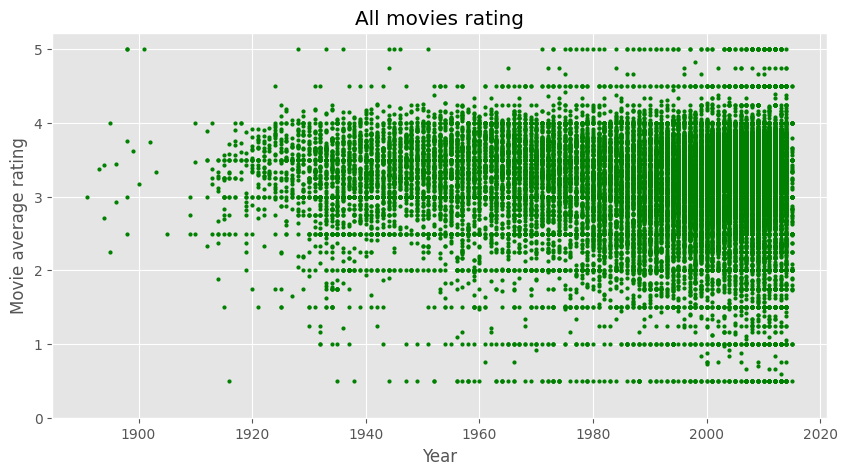

Elapsed time(sec):  0.96


In [ ]:
st = default_timer()

dftmp = movies[['movieId', 'year']].set_index('movieId').join(
    ratings[['movieId','rating']].groupby('movieId').mean())

plt.figure(figsize=(10,5))
plt.plot(dftmp.year, dftmp.rating,"g.", markersize=4)
plt.xlabel('Year')
plt.ylabel('Movie average rating')
plt.title('All movies rating')
plt.ylim(0,)
plt.show()

# Housekeeping
%reset_selective -f (^dftmp$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

**PLOT#6**: Average rating for all movies in each year, and also per genre.

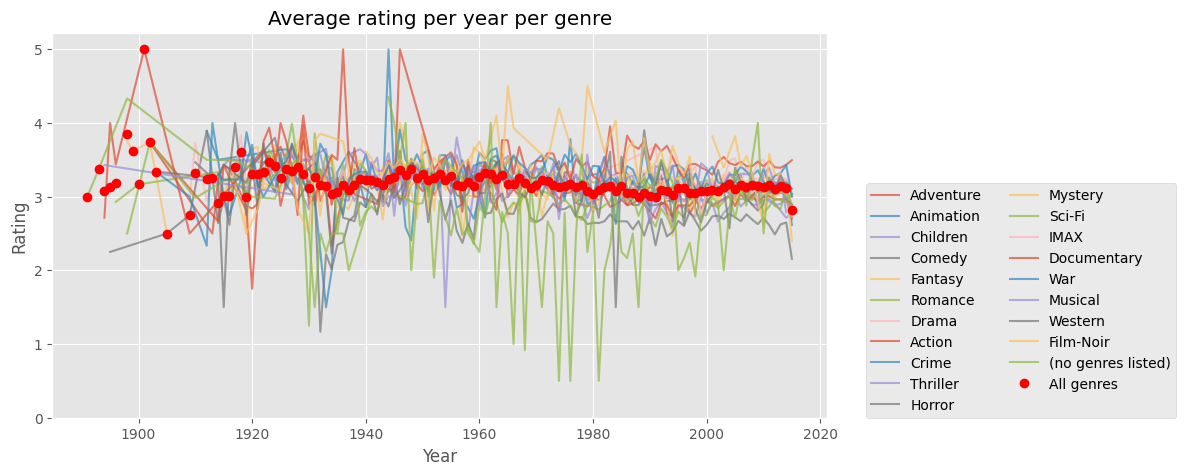

Elapsed time(sec):  14.06


In [ ]:
st = default_timer()

plt.figure(figsize=(10,5))
# For each genre
for genre in genres_unique.genre:
    # Select only movies matching current genre. Pick only movieId (as index) and year.
    dftmp = movies[movies[genre]==True][['movieId', 'year']].set_index('movieId')
    # Selects ratings, with movieId as index. Select only movies that match also the previous step. Join both.
    dftmp = dftmp.join(ratings[ratings.set_index('movieId').index.isin(dftmp.index)][['movieId', 'rating']]
                       .groupby('movieId').mean())
    # Now we have a df of movieId, year and multiple ratings. Group by year and compute the average rating.
    dftmp = dftmp.groupby('year').mean()
    plt.plot(dftmp, label = genre, alpha=0.7)

# For all genres
dftmp = movies[['movieId', 'year']].set_index('movieId')
dftmp = dftmp.join(ratings[ratings.set_index('movieId').index.isin(dftmp.index)][['movieId', 'rating']]
                   .groupby('movieId').mean())
dftmp = dftmp.groupby('year').mean()
plt.plot(dftmp, "o", label='All genres', color='red')

plt.xlabel('Year')
plt.ylabel('Rating')
plt.title('Average rating per year per genre')
plt.legend(loc=(1.05,0), ncol=2)
plt.ylim(0,)
plt.show()

# Housekeeping
%reset_selective -f (^dftmp$|^genre$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

**PLOT#7**: Same as #6, but only the outliers now.

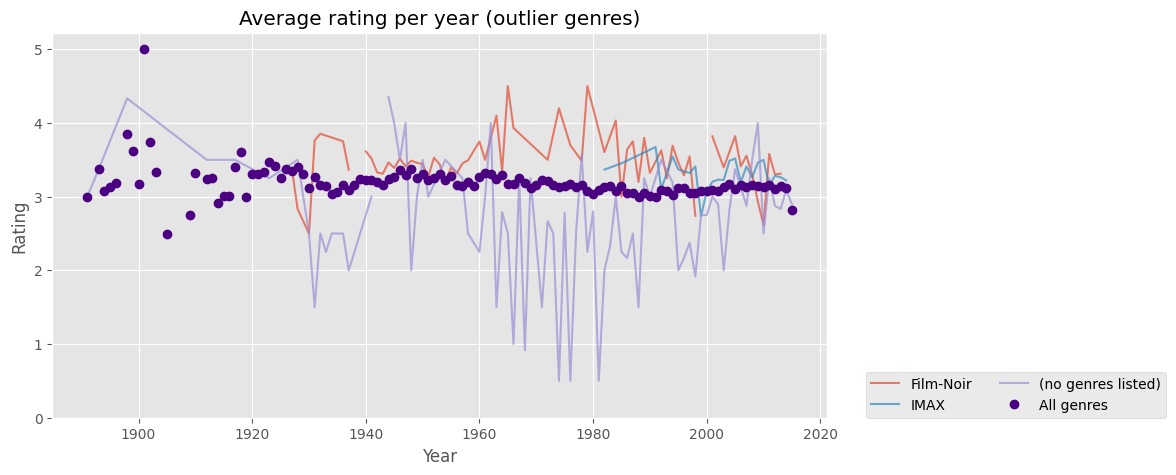

Elapsed time(sec):  3.16


In [ ]:
st = default_timer()

plt.figure(figsize=(10,5))
for genre in outliers:
    # Select only movies matching current genre. Pick only movieId (as index) and year.
    dftmp = movies[movies[genre]==True][['movieId', 'year']].set_index('movieId')
    # Selects ratings, with movieId as index. Select only movies that match also the previous step. Join both.
    dftmp = dftmp.join(ratings[ratings.set_index('movieId').index.isin(dftmp.index)][['movieId', 'rating']]
                       .groupby('movieId').mean())
    # Now we have a df of movieId, year and multiple ratings. Group by year and compute the average rating.
    dftmp = dftmp.groupby('year').mean()
    plt.plot(dftmp, label = genre, alpha=0.7)

# For all genres
dftmp = movies[['movieId', 'year']].set_index('movieId')
dftmp = dftmp.join(ratings[ratings.set_index('movieId').index.isin(dftmp.index)][['movieId', 'rating']]
                   .groupby('movieId').mean())
dftmp = dftmp.groupby('year').mean()
plt.plot(dftmp, "o", label='All genres', color='indigo')
    
plt.xlabel('Year')
plt.ylabel('Rating')
plt.title('Average rating per year (outlier genres)')
plt.legend(loc=(1.05,0), ncol=2)
plt.ylim(0,)
plt.show()

# Housekeeping
%reset_selective -f (^dftmp$|^genre$|^outliers$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

**PLOT#8**: Average ratings per user.

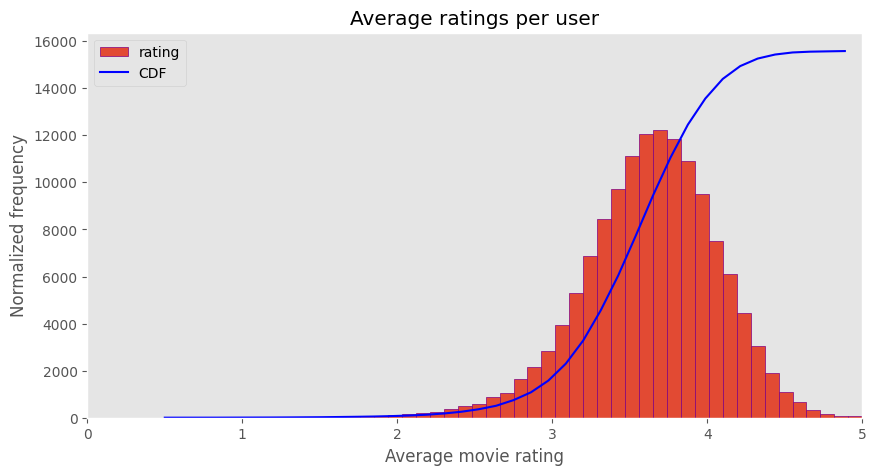

Elapsed time(sec):  1.57


In [ ]:
st = default_timer()

dftmp = ratings[['userId','rating']].groupby('userId').mean()
# Plot histogram
dftmp.plot(kind='hist', bins=50, grid=0, edgecolor='purple', figsize=(10,5))
# Plot cumulative function on top (couldn't do any other way)
# evaluate the histogram
values, base = np.histogram(dftmp, bins=40)
# evaluate the cumulative (multiply by the average distance between points in the x-axis to get UNIT area)
cumulative = np.cumsum(values) * np.diff(base).mean()
# plot the cumulative function
plt.plot(base[:-1], cumulative, c='blue', label='CDF')
plt.xlim(0,5)
plt.legend()
plt.xlabel ('Average movie rating')
plt.ylabel ('Normalized frequency')
plt.title ('Average ratings per user')
plt.show()

# Housekeeping
%reset_selective -f (^dftmp$|^base$|^cumulative$|^values$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

In [ ]:
rating['rating'].mean()

3.5255285642993797

In [ ]:
rating['rating'].max()

5.0

In [ ]:
rating['rating'].min()

0.5

In [ ]:
rating['rating'].median()

3.5

In [ ]:
ratings.corr()

,userId,movieId,rating,timestamp
userId,1.000000,-0.000850,0.001175,-0.002849
movieId,-0.000850,1.000000,0.002606,0.457909
rating,0.001175,0.002606,1.000000,-0.001121
timestamp,-0.002849,0.457909,-0.001121,1.000000


In [ ]:
a= rating['rating']<2
a.head(30)

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
Name: rating, dtype: bool

In [ ]:
c = movies.merge(rating, on='movieId', how='inner')
c.head(20)

,movieId,title,year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,userId,rating,timestamp
0,1,Toy Story,1995.0,False,False,True,True,True,True,False,...,False,False,False,False,False,False,False,3,4.0,1999-12-11 13:36:47
1,1,Toy Story,1995.0,False,False,True,True,True,True,False,...,False,False,False,False,False,False,False,6,5.0,1997-03-13 17:50:52
2,1,Toy Story,1995.0,False,False,True,True,True,True,False,...,False,False,False,False,False,False,False,8,4.0,1996-06-05 13:37:51
3,1,Toy Story,1995.0,False,False,True,True,True,True,False,...,False,False,False,False,False,False,False,10,4.0,1999-11-25 02:44:47
4,1,Toy Story,1995.0,False,False,True,True,True,True,False,...,False,False,False,False,False,False,False,11,4.5,2009-01-02 01:13:41
5,1,Toy Story,1995.0,False,False,True,True,True,True,False,...,False,False,False,False,False,False,False,12,4.0,1997-03-22 20:48:38
6,1,Toy Story,1995.0,False,False,True,True,True,True,False,...,False,False,False,False,False,False,False,13,4.0,1996-11-27 08:21:31
7,1,Toy Story,1995.0,False,False,True,True,True,True,False,...,False,False,False,False,False,False,False,14,4.5,2008-10-29 20:13:59
8,1,Toy Story,1995.0,False,False,True,True,True,True,False,...,False,False,False,False,False,False,False,16,3.0,2001-05-27 13:22:52
9,1,Toy Story,1995.0,False,False,True,True,True,True,False,...,False,False,False,False,False,False,False,19,5.0,1997-02-05 21:03:48
